# Import module and important variable

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import os
#import own module

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
import copy
import psutil
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle
import random
import sys
import time
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from statistics import mean
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
# from attention import Attention
# from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from scipy import stats
from datetime import datetime
from time import sleep
#from geopy import distance 


2023-05-09 20:52:52.078197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__)

2.4.1


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2023-05-09 20:52:57.662148: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-09 20:52:57.663725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-09 20:52:58.075255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:52:58.076240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:52:58.077159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 600

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8671508772482021228,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23569444352
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 6072774317243608221
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5",
 name: "

0000:40:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:52:59.326057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 7 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-09 20:52:59.326086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-09 20:52:59.326109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-09 20:52:59.326118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-05-09 20:52:59.326127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library li

In [4]:
# #check current ram used if needed
# print('Total Ram (GB):', psutil.virtual_memory()[0]/1000000000)
# print('Available (GB):', psutil.virtual_memory()[1]/1000000000)
# print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
# print('RAM memory % used:', psutil.virtual_memory()[2])
# psutil.virtual_memory()

In [5]:
RUN = 'run1_baseline/'
MODEL_NAME = 'CNN_baseline'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/aaEyeTracking/data/
/nfs/ada/jbrook1/users/qdang1/aaEyeTracking/output/run1_baseline/


In [6]:
TASK_TYPE = ['DPT', 'MA', 'PVT', 'VWM']
NORMALIZE_FEATURES = ['Pupil Diameter', 'Pupil X', 'Pupil Y']
TIME_INTERVAL_EACH_SAMPLE = 1
NUMBER_OF_TIME_SAMPLE = 250 * TIME_INTERVAL_EACH_SAMPLE
NUMBER_OF_CHANNELS = 10
NUMBER_OF_INTERVAL_EACH_CHANNEL = NUMBER_OF_TIME_SAMPLE//NUMBER_OF_CHANNELS

# Preprocessing

## Load data

In [7]:
behavior_df = pd.read_pickle(DATA_DIR + 'behavior_data.pickle')
behavior_df

,Task Type,SID,Trial,Stimulus Time,Reaction Time,isCorrectResponse
0,DPT,0,0,1.402413,605.970,1.0
1,DPT,0,0,4.852193,486.175,1.0
2,DPT,0,0,8.401990,443.381,1.0
3,DPT,0,0,11.735102,546.256,1.0
4,DPT,0,0,15.518205,487.143,1.0
...,...,...,...,...,...,...
112195,VWM,57,7,220.884844,322.137,1.0
112196,VWM,57,7,228.184393,379.615,1.0
112197,VWM,57,7,235.350625,352.227,1.0
112198,VWM,57,7,243.966769,353.536,1.0


In [8]:
eye_df = pd.read_pickle(DATA_DIR + 'eye_data.pickle')
eye_df

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
0,DPT,0,0,0.004,5.884283,652.900024,223.100006
1,DPT,0,0,0.008,5.884123,652.799988,223.300003
2,DPT,0,0,0.012,5.883903,653.299988,223.800003
3,DPT,0,0,0.016,5.883621,653.799988,224.399994
4,DPT,0,0,0.020,5.883276,653.400024,224.699997
...,...,...,...,...,...,...,...
157740006,VWM,57,7,274.820,2.233881,554.400024,395.899994
157740007,VWM,57,7,274.824,2.233667,551.400024,399.000000
157740008,VWM,57,7,274.828,2.234875,551.700012,394.899994
157740009,VWM,57,7,274.832,2.237447,550.799988,403.799988


## Interpolation

Total number of data         : 157,740,011  
Total number of missing data :  29,124,939  
Only missing on Pupil X and Pulpil X. Pupil Diameter is already interpolate  
Consecutive missing data describe:  
Count:&emsp;29124939  
Mean:&emsp;728.6144  
Std :&emsp;2694.344  
Min :&emsp;1  
25% :&emsp;32  
50% :&emsp;143  
75% :&emsp;659  
Max :&emsp;71997  

In [9]:
#eye_df.isna().sum()

#This code will get the consecutive missing data 
#temp = eye_df['Pupil X'].isnull().astype(int).groupby(eye_df['Pupil X'].notnull().astype(int).cumsum()).cumsum()

## Normalizing Feature Data

In [10]:
def Fit_data(type_of_scaler, list_of_features, eye_data):
    scaler = {}
    for feature in tqdm(list_of_features, desc='Normalizing Data'):
        current_data = eye_data[feature]
        scaler[feature] = type_of_scaler().fit(np.array(current_data).reshape(-1,1))
    return scaler

def Transform_data(scaler, list_of_features, eye_data):
    eye_data_scaled = copy.copy(eye_data)
    
    for feature in tqdm(list_of_features, desc='Normalizing Data'):
        current_data = eye_data[feature]
        scaled_data = scaler[feature].transform(np.array(current_data).reshape(-1,1))
        eye_data_scaled[feature] = scaled_data
        
    return eye_data_scaled

In [11]:
scaler = Fit_data(StandardScaler, NORMALIZE_FEATURES, eye_df)
eye_df_scaled = Transform_data(scaler,NORMALIZE_FEATURES, eye_df)
eye_df_scaled

Normalizing Data:   0%|          | 0/3 [00:00<?, ?it/s]

Normalizing Data:   0%|          | 0/3 [00:00<?, ?it/s]

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
0,DPT,0,0,0.004,2.014614,1.228511,-1.238277
1,DPT,0,0,0.008,2.014439,1.227608,-1.236659
2,DPT,0,0,0.012,2.014198,1.232125,-1.232612
3,DPT,0,0,0.016,2.013889,1.236642,-1.227757
4,DPT,0,0,0.020,2.013511,1.233028,-1.225329
...,...,...,...,...,...,...,...
157740006,VWM,57,7,274.820,-1.983777,0.338654,0.160170
157740007,VWM,57,7,274.824,-1.984012,0.311551,0.185258
157740008,VWM,57,7,274.828,-1.982688,0.314262,0.152078
157740009,VWM,57,7,274.832,-1.979871,0.306131,0.224104


In [12]:
print(NORMALIZE_FEATURES)
for variable in NORMALIZE_FEATURES:
    print(scaler[variable].mean_)

['Pupil Diameter', 'Pupil X', 'Pupil Y']
[4.04500518]
[516.91381362]
[376.10845024]


## Generate X and Y sample

In [13]:
def Generate_X_Y_sample(TYPE_OF_TASK, SUBJECT_BEGIN, SUBJECT_END, NUMBER_OF_TRIAL, NUMBER_TO_GENERATE,
                        behaviour_data, eye_data):
    behavior_grouped = behaviour_data.groupby(['Task Type', 'SID', 'Trial'])
    eye_grouped = eye_data.groupby(['Task Type', 'SID', 'Trial'])

    X = []
    Y = []
    for task_type in tqdm(TYPE_OF_TASK, desc='Task_type'):
        #for each task_type
        for sid in tqdm(range(SUBJECT_BEGIN, SUBJECT_END), desc='Subject ID'):
            #for each subject id
            for i in range(NUMBER_OF_TRIAL):
                #for each trial
                
                #if the data is not availible, it will raise an error
                try:
                    behavior_temp = behavior_grouped.get_group((task_type,sid,i))
                except:
                    continue
                eye_temp = eye_grouped.get_group((task_type,sid,i))

                for j in behavior_temp['Stimulus Time']:
                    #for each stimulus time, j is the stimulus time
                    for k in range(NUMBER_TO_GENERATE):
                        # k is the number of sample to generate after the time j
                        # the first samples is a positive sample, all sample after the first will the the negative sample

                        ###########################
                        #This code will generate X#
                        ###########################
                        begin = j + k*TIME_INTERVAL_EACH_SAMPLE
                        end = begin + TIME_INTERVAL_EACH_SAMPLE
                        eye_temp2 = eye_temp.query('Time >= @begin and Time <= @end')[NORMALIZE_FEATURES]
                        if eye_temp2.shape[0] == 0:
                            #This is an empty case
                            continue

                        if eye_temp2.isna().sum().sum() != 0:
                            #This is an missing data case, drop the sample
                            continue

                        if eye_temp2.shape[0] == NUMBER_OF_TIME_SAMPLE + 1:
                            #this is an extra sample case, drop the last one
#                             print(eye_temp2.shape, ' sid:', sid, ' i:', i, ' j:', j)
                            eye_temp2 = eye_temp2.drop(eye_temp2.tail(1).index)

                        #this code to cut the sample into smaller channels
                        #if NUMBER_OF_CHANNELS = 10, shape: (250,3,1) -> (25,3,10)
                        eye_temp3 = []
                        for l in range(NUMBER_OF_CHANNELS):
                            #for each channel loop
                            begin_l = l*NUMBER_OF_INTERVAL_EACH_CHANNEL
                            end_l = begin_l + NUMBER_OF_INTERVAL_EACH_CHANNEL
                            eye_temp3.append(eye_temp2[begin_l:end_l])
                            #end l loop
                        eye_temp2 = np.array(eye_temp3).swapaxes(0,2).swapaxes(0,1)
                        
                        
                        X.append(eye_temp2)

                        ###########################
                        #This code will generate Y#
                        ###########################
                        if k == 0:
                            Y_temp = [1]
                        else:
                            Y_temp = [0]
                        Y.append(Y_temp)

                        #end k loop
                    # end j loop
                #end i loop
            #end sid loop
        #end task_type loop

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [16]:
#abnormal shape: (251, 7) and (0, 7)
X_final, Y_final = Generate_X_Y_sample(TASK_TYPE, 0, 53, 10, 3, behavior_df, eye_df_scaled)

Task_type:   0%|          | 0/4 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/53 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/53 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/53 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/53 [00:00<?, ?it/s]

In [17]:
print(X_final.shape)
X_final[0]

(165888, 25, 3, 10)


array([[[ 2.00481979,  2.01144143,  1.92484359,  1.81025029,
          1.665962  ,  1.50721714,  1.37963179,  1.34300387,
          1.34765332,  1.32735282],
        [ 0.30071041,  0.30884076,  0.30884076,  0.97555682,
         -0.74272663, -2.06622038, -2.0824819 , -2.10506712,
         -2.11048762,  2.13463007],
        [ 0.36249209,  0.37382206,  0.41833284,  0.33821349,
          0.25647546,  0.27994498,  0.26375924,  0.27751697,
          0.29532138,  0.2726612 ]],

       [[ 2.00721398,  2.00925928,  1.92077388,  1.80485082,
          1.66026221,  1.50104258,  1.37644737,  1.3430843 ,
          1.34622224,  1.32874682],
        [ 0.30432372,  0.30703438,  0.31426154,  0.96652274,
         -1.10409011, -2.06351026, -2.07977151, -2.11048762,
         -1.9523911 ,  2.12559599],
        [ 0.36896654,  0.3746314 ,  0.41995151,  0.32688352,
          0.26133123,  0.29289337,  0.27913564,  0.27832631,
          0.32040932,  0.27994498]],

       [[ 2.00947813,  2.00690635,  1.91668014, 

In [18]:
print(Y_final.shape)
Y_final[:5]

(165888, 1)


array([[1],
       [0],
       [1],
       [0],
       [0]])

In [19]:
X_test, Y_test = Generate_X_Y_sample(TASK_TYPE, 53, 58, 10, 3, behavior_df, eye_df_scaled)

Task_type:   0%|          | 0/4 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/5 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/5 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/5 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
print(X_test.shape)
X_test

(17789, 25, 3, 10)


array([[[[ 2.36023951e+00,  2.43655704e+00,  2.41637614e+00, ...,
           1.44717845e+00,  1.50992053e+00,  1.65629957e+00],
         [ 2.06537170e-02,  1.11897775e-01,  1.53454906e-01, ...,
           8.30107691e-01,  8.25590647e-01,  8.35528474e-01],
         [-1.62511645e+00, -1.70685447e+00, -1.68338508e+00, ...,
          -1.74489093e+00, -1.73194229e+00, -1.74084450e+00]],

        [[ 2.36607301e+00,  2.43744494e+00,  2.41238164e+00, ...,
           1.44817655e+00,  1.51394846e+00,  1.66430476e+00],
         [ 2.42670209e-02,  1.17318558e-01,  1.60682065e-01, ...,
           8.31914618e-01,  8.25590647e-01,  8.43658821e-01],
         [-1.63159077e+00, -1.69390583e+00, -1.67529221e+00, ...,
          -1.73679806e+00, -1.72870519e+00, -1.74327238e+00]],

        [[ 2.37155865e+00,  2.43820488e+00,  2.40778232e+00, ...,
           1.44931463e+00,  1.51807876e+00,  1.67243269e+00],
         [ 2.51707605e-02,  1.20931862e-01,  1.60682065e-01, ...,
           8.31914618e-01,  8.3281

In [21]:
print(Y_test.shape)
Y_test[:5]

(17789, 1)


array([[1],
       [0],
       [1],
       [0],
       [1]])

## Split

In [22]:
X_train,X_val,Y_train,Y_val = train_test_split(X_final,Y_final,test_size=0.2, random_state=96, shuffle=True)

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(132710, 25, 3, 10)
(33178, 25, 3, 10)
(17789, 25, 3, 10)
(132710, 1)
(33178, 1)
(17789, 1)


# CNN model

In [24]:
#hyper parameter
PATIENCE=20
KERNEL_SIZE =  (3,3)
STRIDES_SIZE = (1,1)
MAX_POOL =  (2,1)
DROPOUT = 0.3
EPOCHS = 100
BATCH_SIZE = 128

In [25]:
# Custom Callback


N = 0
#current_lr = 0.00002
class print_learning_rate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = tf.keras.backend.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLearning Rate: {:.6f}\n'.format(lr))
        lr = float(tf.keras.backend.get_value(optimizer.lr))
        decay = float(tf.keras.backend.get_value(optimizer.decay))
        iterations = float(tf.keras.backend.get_value(optimizer.iterations))
        print('\nLearning Rate: {:.10f}. Decay: {:.10f}. Iteration: {:.10f}\n'.format(lr,decay,iterations))
        
class adjust_learning_rate(tf.keras.callbacks.Callback):   
    def on_epoch_begin(self, epoch, logs={}):
        #first element is epochs, second is new lr
        LR_Table = [
        #(0,current_lr),
        (25 - N, 0.0003),
        (50 - N, 0.0001),
        (75 - N, 0.00003),
        (100 - N, 0.00002),
        (125 - N, 0.00001),]

        if epoch >= LR_Table[0][0] and epoch <= LR_Table[-1][0]:
            for i in range(len(LR_Table)):
                if epoch == LR_Table[i][0]:
                    newlr = LR_Table[i][1]
                    tf.keras.backend.set_value(self.model.optimizer.lr, newlr)
                    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                    print("\nEpoch {}: The New learning rate is {:.6f}.".format(epoch, lr))
                    

def checkpoint_save_weights():
    return tf.keras.callbacks.ModelCheckpoint(OUTPUT_DIR+'model_save/', save_weights_only=True, verbose = 1,save_freq=BATCH_SIZE*5)


cb_print_learning_rate = print_learning_rate()
cb_adjust_learning_rate = adjust_learning_rate()   
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE,verbose=1, min_delta=0.0001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True)

In [32]:
#create model
def create_model(shape, kernel_size, strides_size, max_pool_size, dropout=0.3):
    
    input_layer = tf.keras.Input((shape[1], shape[2], shape[3]))
    
    conv_1 = tf.keras.layers.Conv2D(64, kernel_size, strides=strides_size,  padding='same', activation='relu',)(input_layer)
    conv_1 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(128, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_1)
    conv_2 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    conv_3 = tf.keras.layers.Conv2D(256, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_2)
    conv_3 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_3)
    conv_3 = tf.keras.layers.Dropout(dropout)(conv_3)     
    
    dense_1 = tf.keras.layers.Flatten()(conv_3)
    dense_1 = tf.keras.layers.Dense(32)(dense_1)
    
    output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(dense_1)
    
    model = tf.keras.Model(input_layer, output_layer)
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    return model

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25, 3, 10)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 3, 64)         5824      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 3, 64)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 3, 64)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 3, 128)        73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 3, 128)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 3, 128)         0   

Epoch 43/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3723 - accuracy: 0.8235 - val_loss: 0.4552 - val_accuracy: 0.7835
Epoch 44/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3701 - accuracy: 0.8258 - val_loss: 0.4514 - val_accuracy: 0.7868
Epoch 45/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3680 - accuracy: 0.8272 - val_loss: 0.4594 - val_accuracy: 0.7838
Epoch 46/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3678 - accuracy: 0.8279 - val_loss: 0.4559 - val_accuracy: 0.7862
Epoch 47/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3658 - accuracy: 0.8276 - val_loss: 0.4634 - val_accuracy: 0.7812
Epoch 48/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3660 - accuracy: 0.8283 - val_loss: 0.4595 - val_accuracy: 0.7845
Epoch 49/100
1037/1037 [==============================] - 3s 3ms/step - loss: 0.3641 - accuracy: 0.8292 - val_loss: 0.4608 -

NameError: name 'MODEL_NAME' is not defined

<Figure size 640x480 with 0 Axes>

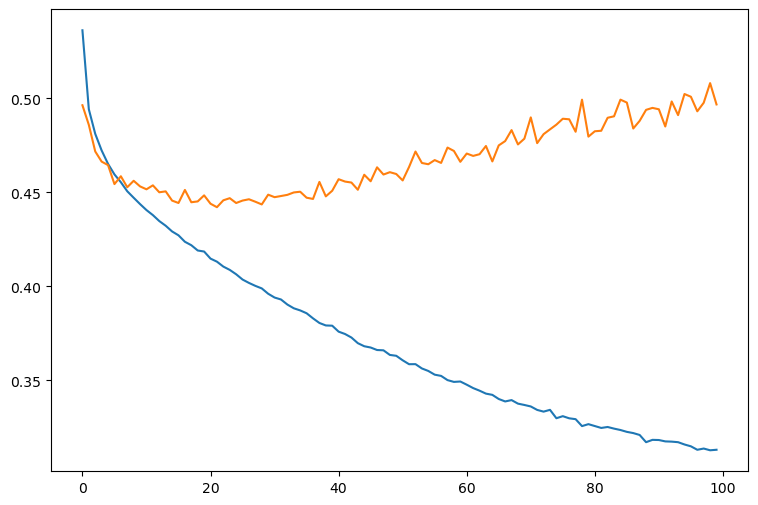

In [33]:
model = create_model(X_train.shape, KERNEL_SIZE, STRIDES_SIZE, MAX_POOL, DROPOUT)
model.summary()

history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), verbose=1, shuffle=False,) #callbacks=[checkpoint_save_weights()])


<Figure size 640x480 with 0 Axes>

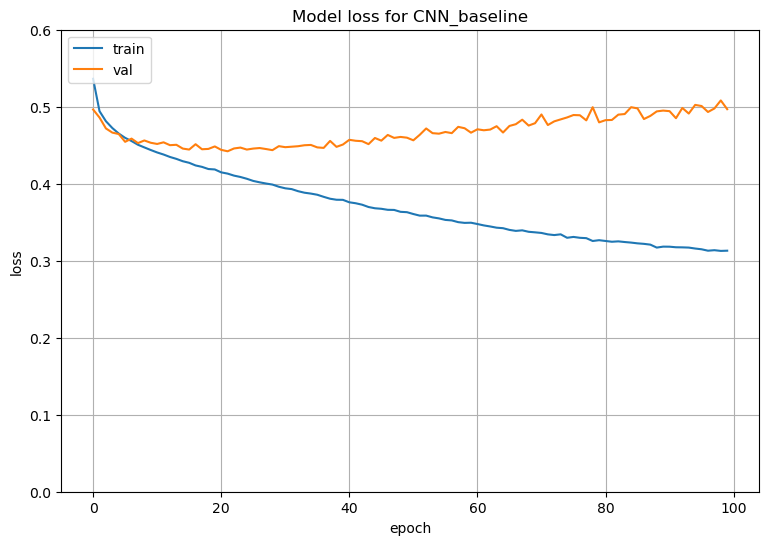

In [38]:
plt.clf()
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for '+ MODEL_NAME)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,0.6])
#plt.xlim([0,200])
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/_training.png", dpi=100)  
plt.show()

# Evaluation

In [41]:
predict = model.predict(X_test,verbose=1)
result = model.evaluate(X_test,Y_test,verbose=1)
Y_predict = []
for y in predict:
    if y <= 0.5:
        Y_predict.append(0)
    else:
        Y_predict.append(1)

556/556 [==============================] - 1s 1ms/step - loss: 0.6041 - accuracy: 0.7124


<Figure size 640x480 with 0 Axes>

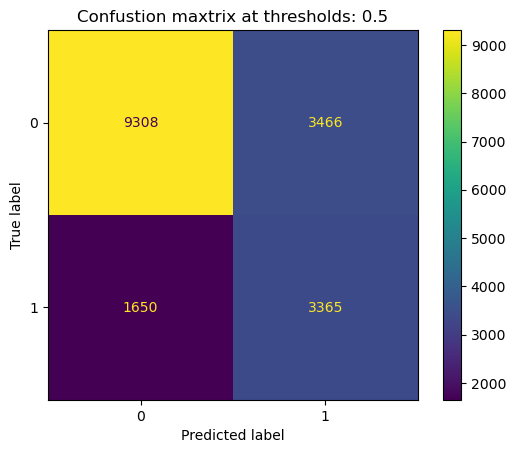

In [67]:
plt.clf()
#plt.figure(figsize=(9,6))
ConfusionMatrixDisplay.from_predictions(Y_predict,Y_test)
plt.title("Confustion maxtrix at thresholds: " + str(0.5))
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/_confusion_matrix.png")  
plt.show()

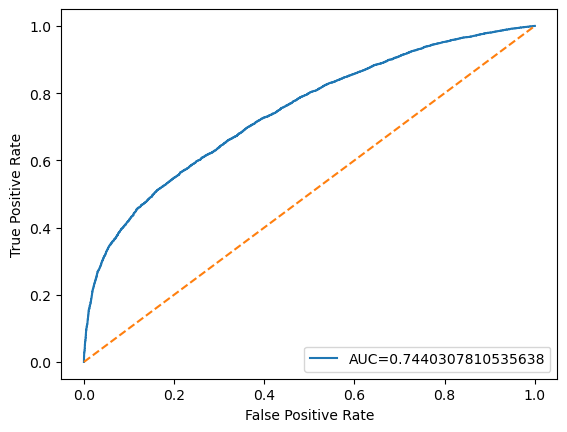

In [54]:
fpr, tpr, _ = roc_curve(Y_test,  predict)
auc = roc_auc_score(Y_test, predict)

plt.clf()
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0,1],[0,1],ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/_ROC.png")  
plt.show()

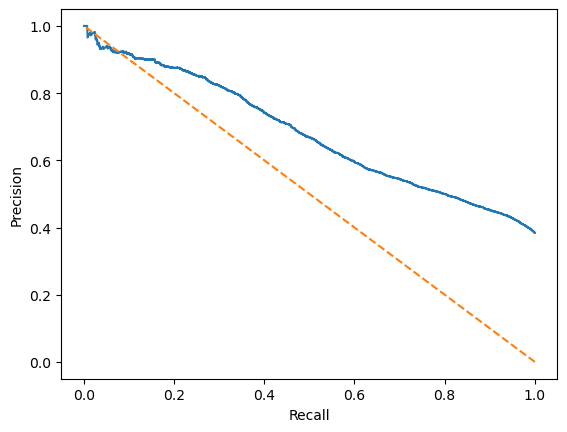

In [64]:
precision, recall, thresholds = precision_recall_curve(Y_test, predict)

plt.clf()
plt.plot(recall, precision)
plt.plot([1,0],[0,1],ls="--")
plt.xlabel('Recall')
plt.ylabel('Precision')
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/_Precision_vs_Recall.png") 
plt.show()

In [81]:
output = []
for i in np.arange(0, 1.1, 0.1):
    Y_predict = []
    for y in predict:
        if y <= i:
            Y_predict.append(0)
        else:
            Y_predict.append(1)
    output.append("Threshold {:.1f}: Accuracy: {:.2f} ,F1: {:.2f}\n".
                  format(i, accuracy_score(Y_test,Y_predict), f1_score(Y_test,Y_predict)) )
#     print('The accuracy is:', f'{result[1]:.2f}')
#     print('F1_score: ', f1_score(Y_true,Y_test))

with open(OUTPUT_DIR+"output.txt", "w") as f:
    for string in output:
        print(string)
        f.write(string)
        f.write('\n')

Threshold 0.0: Accuracy: 0.38 ,F1: 0.55

Threshold 0.1: Accuracy: 0.48 ,F1: 0.59

Threshold 0.2: Accuracy: 0.56 ,F1: 0.61

Threshold 0.3: Accuracy: 0.64 ,F1: 0.61

Threshold 0.4: Accuracy: 0.69 ,F1: 0.59

Threshold 0.5: Accuracy: 0.71 ,F1: 0.57

Threshold 0.6: Accuracy: 0.72 ,F1: 0.53

Threshold 0.7: Accuracy: 0.71 ,F1: 0.50

Threshold 0.8: Accuracy: 0.71 ,F1: 0.45

Threshold 0.9: Accuracy: 0.69 ,F1: 0.37

Threshold 1.0: Accuracy: 0.62 ,F1: 0.00

